В данной работе будет рассмотрен библиотека Speedb и бд RocksDB


# История развития #

Speedb - это движок хранения KVS следующего поколения, который является заменой RocksDB, то есть, дефакто это встроенная библиотека, совместимая с RocksDB, ориентированная на высокую производительность, оптимизированная для современного оборудования хранения данных и масштабируемая локально и в облаке.
 
SPeedb был основан в формате стартапа без офиса в ноябре 2020 года в Израиле тремя коллегами (Adi Gelvan, Hilik Yochai, Mike Dorfman) из компании Enterprise storage unicorn. 
Хилик и его команда изобрели гибридный метод уплотнения, который уменьшает WAF с ~ X30 до ~ X5. После этого команда были готовы пойти и продавать Speedb корпоративным клиентам, которым нужна была масштабируемая встроенная KVS и которые используют RocksDB.

В конце 2020 был подписан стратегический альянс с Redis, в рамках которого Speedb предлагается в качестве механизма хранения данных для клиентов Redis-on-Flash (RoF)

В середине 2021 года Speedb выложили открытый код системы и перевели все технологии в открытый код.

В 2024 году Speedb переехал в офис Redis находящийся в  Cesarea, IL

Также добавлю небольшой очерк про базу которая является включающей в себя библиотеку Speedb - RocksDB.

RocksDB - это встраиваемое постоянное хранилище ключ-значение. Это тип базы данных, разработанный для хранения больших объемов уникальных ключей, связанных с значениями. Простая модель данных ключ-значение может использоваться для создания поисковых индексов, документоориентированных баз данных, SQL-баз данных, систем кэширования и посредников сообщений. Аналог SQLite.

RocksDB была создана как ответвление от Google LevelDB в 2012 году и оптимизирована для работы на серверах с SSD-накопителями. В настоящее время разработка и поддержка RocksDB осуществляется компанией Meta.

# Инструменты для взаимодействия #

Для данной системы реализовано много клиентов на популярных языках программирования (C, C++, Go, Java, Perl, Python, Ruby). Более подробно можно ознакомится со списком по ссылке ниже. 

https://github.com/facebook/rocksdb/wiki/RocksDB-Overview

Так же же пользователю предлагается следующие методы для работы:

Get(key): Позволяет приложению получить одно значение по ключу из базы данных.
NewIterator(): Создаёт новый итератор, который может использоваться для сканирования данных в базе данных. Итераторы могут искать определённый ключ и позволяют приложению последовательно просматривать ключи.
Put(key, val): Вставляет в базу данных одну пару ключ-значение. Если ключ уже существует, предыдущее значение будет перезаписано.
Delete(key): Удаляет ключ из базы данных.
SingleDelete(key): Оптимизированная версия Delete для использования в случае, когда ключ удаляется один раз без перезаписи.
WriteBatch API: Позволяет выполнить несколько операций вставки, обновления или удаления атомарно.
DeleteRange(start_key, end_key): Удаляет все ключи в указанном диапазоне.
MultiGet(keys): Позволяет извлекать значения для списка ключей одновременно, обеспечивая согласованность данных между извлечёнными ключами.
Iterator API: Поддерживает сканирование диапазона в базе данных, а также может использоваться для обратной итерации по ключам.
Snapshot API: Создаёт моментальный снимок базы данных, который можно использовать для чтения, чтобы обеспечить точку согласованного просмотра данных во времени.
Prefix-Seek: Настраивает итератор так, чтобы он использовал фильтр Bloom для оптимизации поиска ключей, начинающихся с определённого префикса.
CompactFiles: Используется для явной компакции выбранных файлов.
DeleteFile: Позволяет удалять файлы данных, которые считаются устаревшими.


# Database engine #
 
(Тк speedb является лишь библиотекой, то я буду рассказывать о конечном продукте который используют разработчики, о RocksDB)
Данная система является высокопроизводительной встроенной базой данных для хранения данных типа "ключ-значение".

Тип баз данных Key-value предназначен для осуществления быстрых, почти мгновенных запросов для таких задач как кэш, отображение баланса и т.д.. Высокая скорость осуществляется за счет хранения данных по принципу ключ-значение, и в большинстве случаев благодаря работе в оперативной памяти. 

Словари содержат коллекцию объектов или записей, а объекты содержат множество различных полей, каждое из которых содержит данные. Записи хранятся и извлекаются с использованием ключа, который однозначно идентифицирует запись и используется для быстрого поиска данных.

Основным применением является ускорение отображения данных для конечных пользователей и снижение нагрузок, в том числе I/O на инфраструктуру организаций.

#### Установка на Linux

git clone https://github.com/facebook/rocksdb.git
sudo apt-get install librocksdb-dev
cd rocksdb

DEBUG_LEVEL=0 make shared_lib install-shared

export LD_LIBRARY_PATH=/usr/local/lib


### Установка на windows

Следуйте одному из трех методов https://github.com/facebook/rocksdb/wiki/Building-on-Windows#method1


# Запросы #

Устновка и настройка базы выходит сложно, если вы не пользователей unix подобных систем. 
В качестве клиента будем использовать Python.
Результаты выводов я буду помечать в формате комментария

Суммарно можно сделать 6 различных типов запросов:

1. put(key, value): сохраняет новую пару ключ-значение или обновляет существующую
2. merge(key, value): объединяет новое значение с существующим значением для данного ключа
3. delete(key): удаляет пару ключ-значение из коллекции
4. get(key): точечный поиск по ключу
5. iterator.seek(key_prefix): "сканирование диапазона", поиск определенного ключа и доступ к последующим парам ключ-значение по порядку

# Сначала просто внёсём данные, удалим их и повторно запишем

In [ ]:
batch = rocksdb.WriteBatch()
db.put("chipmunk", "1")
db.put("cat", "2")
db.put("raccoon", "3")
db.put("dog", "4")
batch.delete(b"chipmunk")

db.write(batch)


# Теперь воспользуемся итераторами

In [ ]:
db.put(b"key1", b"v1")
db.put(b"key2", b"v2")
db.put(b"key3", b"v3")

it = db.iterkeys()
it.seek_to_first()

# prints [b'key1', b'key2', b'key3']
print list(it)

it.seek_to_last()
# prints [b'key3']
print list(it)

it.seek(b'key2')
# prints [b'key2', b'key3']
print list(it)

# Существуют также методы для перебора значений/элементов:

In [ ]:
it = db.itervalues()
it.seek_to_first()

# prints [b'v1', b'v2', b'v3']
print list(it)

it = db.iteritems()
it.seek_to_first()

# prints [(b'key1', b'v1'), (b'key2, b'v2'), (b'key3', b'v3')]
print list(it)

# Обратная итерация:

In [ ]:
db.put(b'a1', b'a1_value')
db.put(b'a3', b'a3_value')
db.put(b'b1', b'b1_value')
db.put(b'b2', b'b2_value')
db.put(b'c2', b'c2_value')
db.put(b'c4', b'c4_value')

it = db.iteritems()
it.seek(b'a1')
assertEqual(it.get(), (b'a1', b'a1_value'))
it.seek(b'a3')
assertEqual(it.get(), (b'a3', b'a3_value'))
it.seek_for_prev(b'c4')
assertEqual(it.get(), (b'c4', b'c4_value'))
it.seek_for_prev(b'c3')
assertEqual(it.get(), (b'c2', b'c2_value'))

# Создание Снапшотов удобно для получения согласованного представления о базе данных:

In [ ]:
self.db.put(b"a", b"1")
self.db.put(b"b", b"2")

snapshot = self.db.snapshot()
self.db.put(b"a", b"2")
self.db.delete(b"b")

it = self.db.iteritems()
it.seek_to_first()

# prints {b'a': b'2'}
print dict(it)

it = self.db.iteritems(snapshot=snapshot)
it.seek_to_first()

# prints {b'a': b'1', b'b': b'2'}
print dict(it)

# Поддержка распределение файлов БД по разным носителям #

RocksDB поддерживает распределение файлов базы данных по разным носителям хранения. Это можно настроить с помощью различных параметров конфигурации. Один из способов это сделать — использовать разные директории для размещения различных типов файлов, таких как файлы журналов (WAL) и файлы таблиц (SST).

Конфигурация для разных носителей
В RocksDB можно указать разные пути для следующих компонентов:

Файлы журналов (Write-Ahead Logs - WAL):
Журналы предварительной записи (WAL) критичны для восстановления после сбоев и обеспечивают прочность данных. Их можно настроить так, чтобы они сохранялись на более надежных, но возможно более медленных носителях.
Файлы SST (Sorted String Table):
Эти файлы содержат фактические данные и могут быть размещены на более быстрых носителях для ускорения чтения и записи данных.

Пример конфигурации
В коде на C++ это можно настроить следующим образом:



In [ ]:
#include <rocksdb/db.h>
#include <rocksdb/options.h>

int main() {
    rocksdb::DB* db;
    rocksdb::Options options;
    options.create_if_missing = true;

    // Указываем различные директории для файлов журнала и SST файлов
    options.db_paths = {
        {"/path/to/sstfiles1", 1024 * 1024 * 1024},  // Путь для SST файлов и макс размер в байтах
        {"/path/to/sstfiles2", 1024 * 1024 * 1024}
    };
    options.wal_dir = "/path/to/walfiles";  // Путь для файлов журнала

    // Открываем базу данных с настройками
    rocksdb::Status status = rocksdb::DB::Open(options, "/path/to/db", &db);
    if (!status.ok()) {
        std::cerr << "Unable to open/create database: " << status.ToString() << std::endl;
        return 1;
    }

    // Далее можно выполнять операции с базой данных
    delete db;
    return 0;
}


# Процесс выполнения запросов

В RocksDB, как в базе данных типа key-value, основанной на LSM-дереве (Log-Structured Merge-tree), процесс выполнения запросов отличается от традиционных реляционных СУБД. Вот как можно описать типичный процесс выполнения запросов в RocksDB:

### Запись данных (Write)

1. **Подготовка**: При выполнении операции записи (`Put`, `Delete`, `Merge`) данные сначала записываются во внутреннюю структуру данных, называемую `memtable`. Это быстрая операция, так как `memtable` хранится в оперативной памяти.
    
2. **Журналирование**: Параллельно с записью в `memtable`, данные также могут быть записаны в журнал предварительной записи (Write-Ahead Log, WAL), который находится на диске. Это обеспечивает устойчивость данных в случае сбоя системы.
    
3. **Сброс на диск**: Когда `memtable` заполняется, она становится неизменяемой (`immutable memtable`) и асинхронно сбрасывается на диск в виде SST-файла (Sorted String Table). Этот процесс называется сбросом (`flush`).
    
4. **Компакция**: Со временем SST-файлы компактируются и объединяются, чтобы уменьшить их количество и улучшить производительность чтения. Компакция включает в себя слияние нескольких SST-файлов в один файл, оптимизацию распределения данных по уровням хранения и удаление устаревших или удалённых записей.
    

### Чтение данных (Read)

1. **Поиск в `memtable`**: При запросе на чтение (например, через `Get` или `Iterator`) RocksDB сначала проверяет, есть ли искомый ключ в текущей `memtable` и неизменяемых `memtables`.
    
2. **Поиск в кэше блоков**: Если ключ не найден в `memtables`, RocksDB проверяет, находится ли соответствующий блок данных в кэше блоков (если он настроен).
    
3. **Поиск в SST-файлах**: Если данных нет ни в `memtables`, ни в кэше блоков, система производит последовательный поиск по SST-файлам, начиная с самого нового уровня. SST-файлы на каждом уровне индексируются, и поиск ускоряется с помощью индексных блоков и Bloom фильтров.
    
4. **Bloom фильтры**: Прежде чем обращаться к диску для поиска ключа в SST-файле, RocksDB может использовать Bloom фильтр для быстрой проверки, содержится ли ключ в файле, что снижает количество дорогостоящих операций ввода-вывода.
    

### Удаление данных (Delete)

- **Мягкое удаление**: Команды удаления (`Delete` или `SingleDelete`) просто записывают специальную запись (tombstone), которая указывает на то, что ключ был удален. Эти записи удаляются только во время процесса компакции.


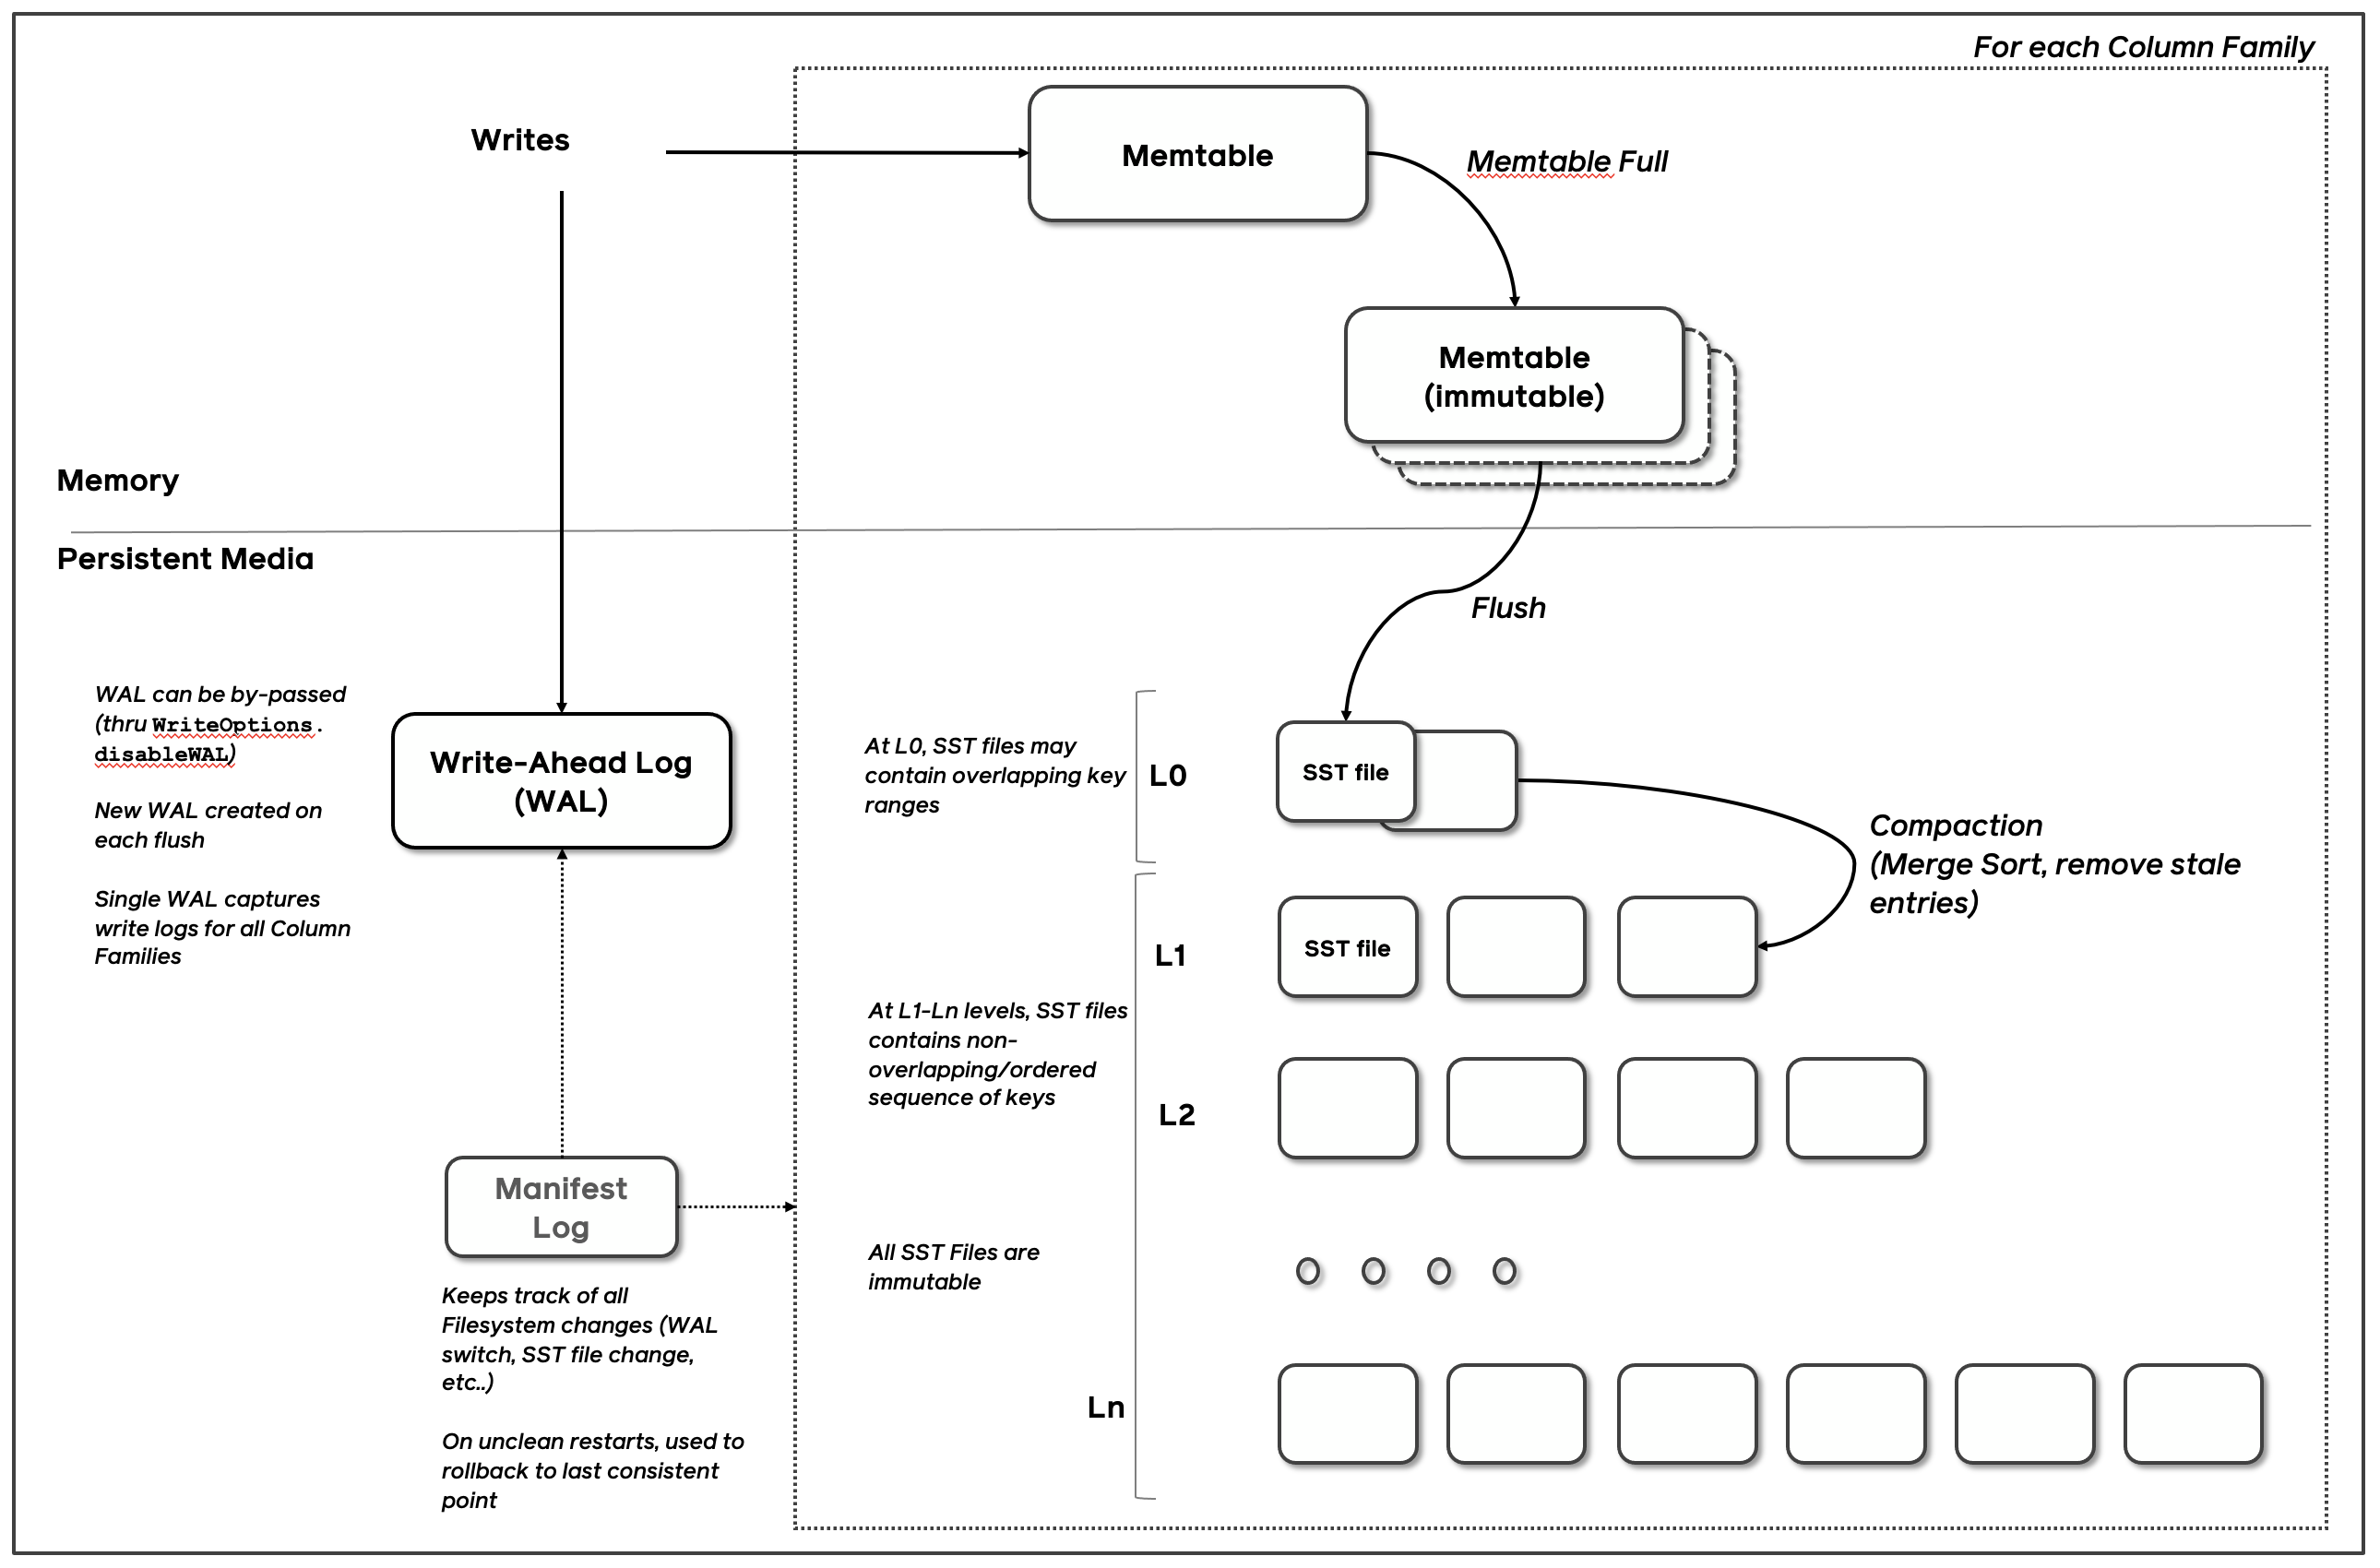

# Язык программирования 

RocksDB написана на C++, поэтому, помимо C и C++, библиотека также имеет привязки для языков Си, что позволяет встраивать библиотеку в приложения, написанные на других языках, таких как Rust, Go или Java.

# План запросов 

В RocksDB, как в базе данных на основе LSM-дерева (Log-Structured Merge-tree), нет понятия «план запросов»

# Транзакции 

RocksDB поддерживает транзакции, но они реализованы несколько иначе, чем в традиционных реляционных СУБД.

RocksDB предоставляет поддержку транзакций с использованием двух основных режимов:

1. **Оптимистичные транзакции (Optimistic Transactions)**:
    
    - В оптимистичном режиме RocksDB предполагает, что конфликты между транзакциями возникают редко. Транзакции выполняются без блокировки данных во время их выполнения.
    - Конфликты проверяются только в момент фиксации транзакции (`commit`). Если обнаруживается конфликт (другая транзакция изменила данные, которые текущая транзакция собиралась изменить), то фиксация транзакции отклоняется.
    - Этот метод подходит для приложений, где конфликты маловероятны, и он позволяет избежать издержек блокировок.
2. **Пессимистичные транзакции (Pessimistic Transactions)**:
    
    - В пессимистичном режиме RocksDB использует блокировки для управления доступом к данным, которые могут изменяться в рамках транзакции.
    - Каждая операция в транзакции, которая может модифицировать данные, приобретает блокировку на соответствующие ключи до тех пор, пока транзакция не будет завершена. Это обеспечивает, что другие транзакции не могут одновременно модифицировать те же данные.
    - Пессимистичные транзакции лучше подходят для сценариев с высокой конкуренцией или когда вероятность конфликтов высока.

# Основные дополнения от Speedb вносящиеся в Rocksdb

1. Sorted Hash Memtable:

Speedb ввела новый тип таблицы памяти, который значительно улучшает производительность поиска и чтения во время записи, обеспечивая эффективную параллельную обработку без необходимости блокировок синхронизации. Эта инновация делает Speedb особенно привлекательной для сценариев, где высокая производительность записи сочетается с интенсивными запросами на чтение и поиск.

**Технические детали**

Новая таблица памяти использует сочетание хэша и отсортированных векторов для оптимизации операций. Хэш разделен на 1 миллион сегментов, что минимизирует коллизии и обеспечивает быстрый доступ по ключу (O(1)). Отсортированные векторы улучшают операции поиска, обеспечивая эффективность даже во время активных операций записи.

**Процесс записи и чтения**

- **Запись**: Процесс включает добавление записей в хэш и список записей атомарно, что позволяет поддерживать высокую производительность без блокировок.
- **Чтение**: Операции чтения выполняются с прямым доступом к корзинам хэша, что ускоряет получение данных.
- **Поиск**: Запросы на поиск инициируют процесс сортировки в фоновом режиме, что обеспечивает актуальность отсортированных векторов и повышает эффективность последующих операций поиска.

**Преимущества и недостатки**

- **Преимущества**:
    
    - Высокая производительность при интенсивной записи.
    - Операции записи не блокируют запросы поиска.
    - Отсортированные векторы улучшают поиск без необходимости копирования данных.
    - При отсутствии новых записей между двумя операциями поиска оба итератора используют один и тот же отсортированный вектор, что повышает производительность.
- **Недостатки**:
    
    - Высокая стоимость создания таблицы памяти из-за размера и сложности конструктора.
    - Создание миллиона сегментов требует значительного времени и ресурсов.

2. Динамическая задержка записи

Speedb v2.2.0 внедрила механизм динамических задержек записи (Dynamic Delayed Writes), который стабилизирует производительность за счет альтернативного метода расчета скорости задержки записи. Этот механизм использует флаг use_dynamic_delay и адаптирует скорость задержки на основе текущего состояния LSM (Log-Structured Merge-tree), учитывая такие параметры, как количество файлов на уровне L0 и ожидаемые байты компакции.

# Мотивация

Традиционные методы задержки записи не всегда эффективно реагировали на изменения состояния LSM, что приводило к неоправданным спайкам производительности записи. Новый подход предлагает более гибкую настройку, позволяя увеличивать или уменьшать задержку в зависимости от степени нарушения установленных ограничений.

# Детали реализации

Механизм адаптирует задержку записи, исходя из количества нарушений ограничений, таких как:

Количество файлов L0.
Ожидаемые байты компакции.
Состояние последней memtable.
Расчет новой скорости задержки выполняется функцией CalculateWriteDelayDivider, вызываемой через RecalculateWriteStallConditions и DynamicSetupDelay.

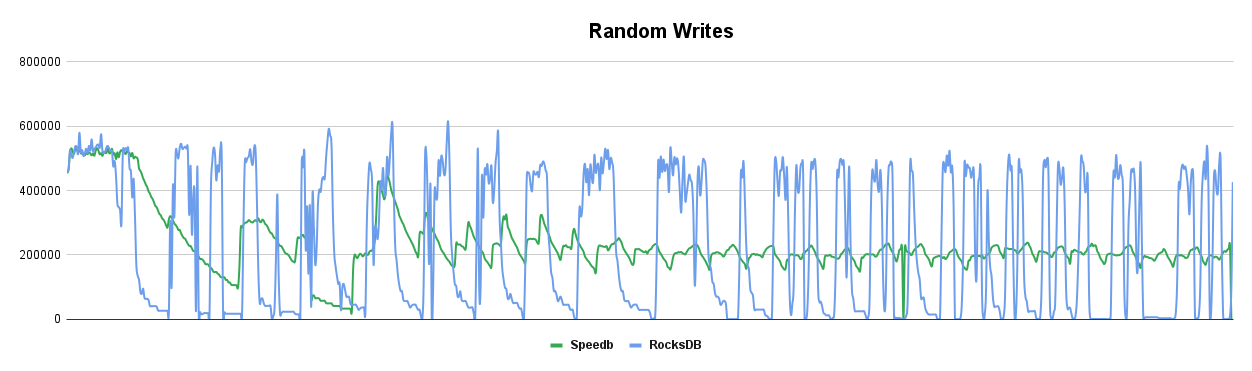

# Методы восстановления 

RocksDB предоставляет несколько механизмов для восстановления данных после сбоев. Вот основные методы восстановления, поддерживаемые в RocksDB:

### 1. Write-Ahead Logging (WAL)

Write-Ahead Logging (WAL) — это стандартный метод для обеспечения устойчивости данных в базах данных. В RocksDB каждая операция записи сначала регистрируется в журнале WAL, который сохраняется на диске, прежде чем актуальные изменения будут применены к данным в `memtable`. Это обеспечивает возможность восстановления после сбоя, так как все незавершённые или частично выполненные операции могут быть повторно выполнены с помощью записей в WAL.

При перезапуске базы данных RocksDB проходит через WAL и воспроизводит все операции записи, чтобы восстановить состояние базы данных до момента последнего сбоя.

### 2. Checkpointing

Checkpointing — это процесс создания точки сохранения (snapshot) текущего состояния базы данных, который полностью независим от журнала WAL и может использоваться для восстановления базы данных в точке создания контрольной точки. В RocksDB создание контрольной точки включает в себя копирование всех SST файлов и текущего состояния `memtable` на момент создания контрольной точки.

Этот метод полезен для создания резервных копий без остановки сервиса и обеспечивает быстрое восстановление до последней контрольной точки без необходимости переигрывать все записи из WAL.

### 3. Snapshotting

RocksDB позволяет создавать моментальные снимки (`snapshots`) состояния базы данных, которые представляют собой только чтение и точку во времени, когда они были созданы. Снимки могут быть использованы для создания консистентных резервных копий или для обеспечения стабильного представления данных для операций чтения, независимо от параллельно выполняемых операций записи.

Однако, важно отметить, что снимки в RocksDB не сохраняются через перезагрузки базы данных, и после перезапуска все предыдущие снимки теряются.

### 4. **Backup Engine**

RocksDB предлагает встроенный API для резервного копирования и восстановления, известный как `BackupEngine`. Этот инструмент позволяет создавать полные и инкрементные резервные копии базы данных, которые могут быть сохранены в отдельном месте и восстановлены при необходимости. `BackupEngine` обрабатывает как данные (`sst` файлы), так и метаданные для обеспечения целостности резервных копий.

# Шардинг 

RocksDB сама по себе не предоставляет встроенные механизмы для шардинга и данных на уровне базы данных, поскольку это встраиваемая библиотека хранения данных, а не полноценная серверная СУБД. Однако, благодаря своей высокой производительности и гибкости, RocksDB часто используется в крупных распределённых системах, где реализация шардинга ложится на плечи прикладного уровня или на другие компоненты системы.

# Безопасность

### 1. **Шифрование данных на уровне хранения**

RocksDB поддерживает шифрование данных на уровне хранения через плагины или сторонние расширения. Возможно использование шифрования файлов SST (Sorted String Table) для обеспечения безопасности данных на диске. Это может быть реализовано с помощью Env Encryptors в RocksDB, которые позволяют зашифровать данные перед их записью на диск и расшифровать данные при их чтении.

### 2. **Контроль целостности данных**

RocksDB использует контрольные суммы для обеспечения целостности данных на уровне хранения. Каждый блок данных в SST файле сопровождается контрольной суммой, что позволяет обнаруживать повреждения данных из-за аппаратных сбоев или внешних воздействий.

### 3. **Безопасное удаление данных**

Для сценариев, требующих гарантию удаления данных, RocksDB предоставляет API для удаления данных, где данные могут быть не только помечены как удалённые, но и физически удалены из хранилища во время процесса компакции.

# Data Mining, Data Warehousing и OLAP

RocksDB, будучи высокопроизводительной встраиваемой базой данных для хранения пар ключ-значение, первоначально не предназначена для традиционных сценариев Data Mining, Data Warehousing и OLAP (Online Analytical Processing).

# Сообщества развивающие продукт

RocksDB разрабатывается и поддерживается широким сообществом разработчиков, включая как индивидуальных контрибьюторов, так и крупные компании. Проект является открытым и доступен на GitHub, что позволяет различным участникам вносить свой вклад в его разработку.

### Основные участники и организации

1. **Facebook**:
    
    - RocksDB был первоначально разработан в Facebook для использования в их инфраструктуре. Facebook до сих пор играет ключевую роль в разработке и поддержке базы данных, внося значительные ресурсы в обслуживание и улучшение проекта.
    - Большинство основных улучшений и новых функций происходит при активном участии инженеров из Facebook.
2. **LinkedIn**:
    
    - LinkedIn активно использует RocksDB и вносит свой вклад в его разработку, особенно в аспектах, связанных с производительностью и масштабируемостью для обработки больших объемов данных.
3. **Alibaba**:
    
    - Alibaba также внесла значительный вклад в RocksDB, особенно в разработку и поддержку функций, связанных с управлением и масштабированием производительности в своих масштабируемых приложениях.

# Данные для тестов #

В качестве данных для тестов используются данные сотрудников с личной информацией(данные, естественно не настоящих людей).

Файл будет приложен к ноутбуку ( ```contacts.json``` ).

# Документация и гайды #

Так как RocksDB и Speedb это проекты с открытым исходным кодом, то они постоянно изменяются и показывают некоторые отвлевления. Демобазы представлены на самих сайтах, в случае необходимости в сообществе есть куча различных баз. 
Основную информацию можно найти по следующим ссылкам:

https://github.com/facebook/rocksdb/wiki
https://git.codeproxy.net/speedb-io/speedb?tab=readme-ov-file

Гайды по установке и началу работы представлены ниже:

https://docs.speedb.io/getting-started
https://rocksdb.org/docs/getting-started.html



# Новости #

Чтобы быть в курсе обновлений следите за Speedb и Rockdb  на официальном сайте и в социальных сетях


https://twitter.com/RocksDB

https://www.meetup.com/RocksDB

https://www.facebook.com/groups/rocksdb.dev/

https://rocksdb.org/

https://groups.google.com/forum/#!forum/rocksdb

https://www.youtube.com/@speedb8992

https://www.linkedin.com/company/speedb-io

https://twitter.com/speedb_io

https://discord.com/invite/5fVUUtM2cG

# Данные для тестов #

В качестве данных для тестов используются данные сотрудников с личной информацией(данные, естественно не настоящих людей).

Файл будет приложен к ноутбуку ( ```contacts.json``` ).

# Заключение #

RocksDB — это высокопроизводительная встраиваемая база данных типа ключ-значение, разработанная Facebook для обеспечения устойчивости и эффективности при работе с большим объемом данных на SSD. Она отлично подходит для систем, где необходим быстрый доступ к данным с низкой задержкой. Благодаря своей архитектуре на основе LSM-дерева, RocksDB обеспечивает эффективную запись и компакцию данных, что делает ее идеальной для использования в мобильных приложениях, встраиваемых системах и при разработке высоконагруженных серверных решений. Основные недостатки включают отсутствие встроенных средств для сложных запросов и аналитики, что может потребовать дополнительных усилий для интеграции с внешними системами.

Speedb, будучи расширением возможностей RocksDB, предлагает дополнительные функциональности. Это делает Speedb более привлекательным выбором для предприятий, которым нужна масштабируемость традиционных реляционных СУБД в сочетании с производительностью NoSQL-решений. Speedb улучшает управляемость, поддержку и безопасность, что важно для крупных корпоративных приложений. Однако, стоимость внедрения и поддержки Speedb может быть выше по сравнению с более простыми решениями, такими как RocksDB.